<div class="report-header"><div class="aictx-logo"></div>
<span class="report-type">Documentation</span><br />
<span class="report-author">Author: Felix Bauer</span><br />
<span class="report-date">22nd August, 2018</span>
</div><h1>RecDIAF:</h1><h1>Recurrent layer of digital I&F neurons</h1>

This document illustrates how to use the `RecDIAF` (<b>Rec</b>urrent <b>D</b>igital <b>I</b>ntegrate <b>A</b>nd <b>F</b>ire) layer, an event-based recurrent layer of digital integrate and fire neurons with constant leak.

##### Housekeeping and import statements


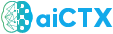

In [1]:
# - Import required modules and configure; set report style 

import os, sys
strToolboxPath = os.path.abspath("../../")
if strToolboxPath not in sys.path:
    sys.path.append(strToolboxPath)

# - Initialisation code to include custom report styles
from IPython.core.display import HTML
def css_styling():
    styles = open("aictx-report.css", "r").read()
    return HTML(styles)
css_styling()

## Neuron model

<br>

### Digital neurons

Neurons of this layer are digital in the sense that their states are given by integers. Their value range is defined by choosing a particular integer type. States are clipped within this range so that it cannot be exceeded. Any other variable, such as weights and reset values can in theory be a non-integer number. In this case the updated state will be rounded down.

Any time-related variable, such as leak interval, refractoriness, event times or evolution times are real valued.

<br>

### State evolution

The layer consists of `nSize` neurons and an `nSizeIn`-dimensional input. The neurons' states at time $t$ are described by the vector $\mathbf{v}(t)$ (`vState`). A constant value `vfCLeak` is periodically subtracted every `tTauLeak` seconds. Note that this leak is essentially a negative bias. Positive values for `vfCLeak` reduce the states periodically, negative values will increase them. The leak can be chosen for each neuron individually.

If a neuron receives a spike, the corresponding weight will be added to its status. Weights for external input spikes are defined in `mfWIn`, recurrent weights in `mfWRec`. Input spikes are processed immediately. Before recurrent spikes, there is a delay between actual spike time and the time the neurons receive it, which can be set with `tSpikeDelay`.

<br>

### Spiking

When a neuron's state variable exceeds a threshold, one of two mechanisms is activated:
1. The neuron emits a spike and fixed value is subtracted from the neuron state (`vState`).
2. The neuron emits a spike and its state is reset to a predefined value. No matter how far the threshold is exceeded, the neuron only spikes once.

The threshold, the value that is subtracted from the neuron state as well as the value the state is reset to can be individually set for each neuron in the layer's `vfVThresh`, `vfVSubtract` and `vfVReset` attributes, respectively. As long as `vfVSubtract` is not `None`, the subtraction mechanism (1) kicks in, otherwise the reset mechanism (2). This behavior can only be changed on the layer-level, not for individual neurons.

<br>

### Refractoriness

After a neuron spikes, it will be refractory for a time defined individually for each neuron in `vtRefractoryTime`. During this period its state will neither be affected by any incoming spikes, nor by the leak. It will not spike, even if its state is still above threshold, which can happen if the subraction mechanism is active. Non-zero refractory times can help increase network stability. By default, the refractory time cannot be set to a lower value than `1e-9`. This minimum can be changed by setting `<Layer>._tMinRefractory`, where `<Layer>` is the layer instance.

<br>

## Import

In [2]:
# - Import recurrent RecDIAF layer
from NetworksPython.layers import RecDIAF

<br>

## Instantiation
`RecDIAF` objects are instantiated with the following arguments:

| Argument | Type | Default | Meaning |
|----------|------|---------|---------|
| `mfWIn` | 2D-`ndarray`| - | Input weights (required) |
| `mfWRec` | 2D-`ndarray` | - | Recurrent weights (required)
| `tDt` | `float` | `1e-4` | Time step |
| `tSpikeDelay` | `float` | `1e-8` | Delay for recurrent spikes |
| `tTauLeak` | `float` | `1e-3` | Period for applying leak |
| `vtRefractoryTime` | `float` | `1e-9` | Refractory time |
| `vfVThresh` | `ArrayLike` or `float` | 100 | Spiking threshold |
| `vfVReset` | `ArrayLike` or `float` | 0 | State reset values |
| `vfCleak` | `ArrayLike` or `float` | 1 | Constant leak (negative bias) |
| `vfVSubtract` | `ArrayLike`, `float` or None | `None` | Values for subtraction |
| `strDtypeState` | `str` | `"int8"` | Data type for membrane potential |
| `strName` | `str` | "unnamed" | Layer name |

`mfWIn` and `mfWRec` are the input and recurrent weights and have to be provided as 2D-arrays.

`tDt` is a positive `float`. Because the layer is event-driven, it is mainly there for compatibility with the `Network` object. However, it does affect the evolution duration, which is always a multiple of `tDt`.

`tSpikeDelay` determines the time takes after a layer neuron spikes until the spike is received by the layer neurons. `tTauLeak` is the interval after which the leak is subtracted from the neuron states. Each of these two values is a single `float` that is the same for all neurons. `vtRefractoryTime` is an array determining each neuron's refractory time individually. It is lower bounded by `1e-9` (see above). Instead of an array, a single `float` can be passed, to assign the same value to all neurons.

`vfCLeak` and `vfVThresh` define each neuron's constant leak and spiking threshold. This can either be an array-like object of size `nSize` or a single `float` which is then applied to all neurons. The same holds for `vfVReset`, which determines the neuron states at instantiaion, when the `reset_state()` or `reset_all()` methods are called or when the neuron spikes and `vfVSubtract` is `None`.
Apart from `None`, `vfVSubtract` can be an array-like or a `float`, in which case it determines the values that are subtracted from spiking neurons instead of resetting them.

The data type of the neuron states is defined by `strDtypeState`, which should be a string that is understood by the `numpy` package. Above all, `strDtypeState` determines the value range of the neuron states.

`strName` is a `str` that defines the layer's name. 

All of these values can be accessed and changed via `<Layer>.value`, where `<Layer>` is the instance of the layer.

<br>

## Evolution

The `evolve` method takes the standard arguments `tsInput`, `tDuration`, `nNumTimeSteps` and `bVerbose`, which is currently not being used. Evolution duration is determined by the usual rules. If `tsInput` is provided, it must be a `TSEvent` object.

Neurons will evolve and spike as described above. The method will return a `TSEvent` object containing the timings and IDs of the layer neurons' spikes. If there are spikes from neurons within the layer, that due to the spike delay would only be received after the end of the evolution period, they will be processed at the correct times during the next evolution.

<br>

## Resetting

As usual the layer's time and state can be reset by the `reset_time`, `reset_state` and `reset_all` methods. When resetting the state, `vState` is set to `vfVReset`. Additionally, spikes from the previous evolution time step do not have any effect on future evolutions.

<br>

## Internal methods

```
_prepare_input(
    tsInput: Optional[TSEvent] = None,
    tDuration: Optional[float] = None,
) -> (np.ndarray, float)
```
Called by evolve, which passes it its `tsInput` and `tDuration` arguments. `_prepare_input` will determine the correct evolution duration (which is always a multiple of `tDt`. It then returns the event times from `tsInput`,  the corresponding channel IDs, the evolution duration and the layer time after evolution.

<br>

## Class member overview

<br>

### Methods
| Method | Description |
|--------|-------------|
| `_prepare_input` | Extract input data, determine evolution duration |
| `evolve` | Evolve layer |
| `reset_all` | Reset neuron states and layer time|
| `reset_state` | Reset neuron states |
| `reset_time` | Reset layer time to 0 |
| `randomize_state` | Randomize neuron states to integer values within the value range. |
<i> Internal methods of parent class</i> `Layer` <i> are listed in corresponding documentation. </i>

<br>

### Attributes

Each argument that described in section Instantiation has a corresponding attribute that can be accessed by `<Layer>.<attribute>`, where `<Layer>` is the layer instance and `<attribute>` the argument name. Furthermore there are a few internal attributes:

| Attribute name | Description |
|----------------|-------------|
| `_heapRemainingSpikes` | Heap of tuples containing the time and source ID of spikes that have not been processed, yet. |
| `_mfWTotal` | 2D-`ndarray` of shape (`nSizeIn` + `nSize` + 2 , `nSize`), used during evolution for processing events |
| `_nLeakChannel` | Leak is treated as a series of events. This is the channel ID assigned to them. |
| `_nStateMax` | Largest possible value for `vState` |
| `_nStateMin` | Smallest possible value for `vState` |
| `_tMinRefractory` | Minimum allowed refractory period |


#### Colophon
Live notebook requires a Jupyter Notebook server.

GitLab repository location: https://gitlab.com/ai-ctx/network-architectures/blob/master/Projects/Documentation/FFCLIAF%20and%20RecCLIAF.ipynb